## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Кежаев Максим ML-21

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [4]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [5]:
images_train, labels_train = next(iter(train_loader))

In [6]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

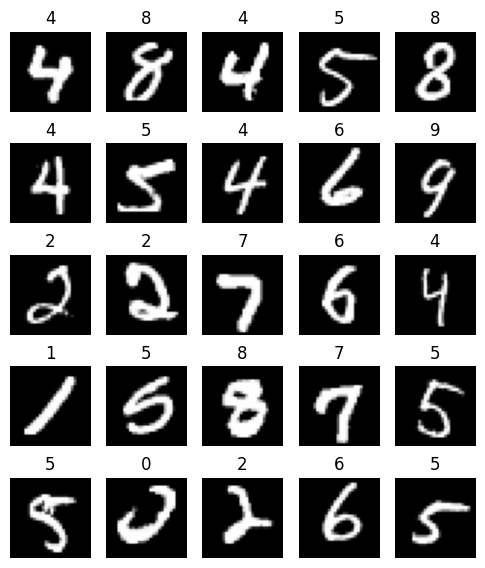

In [7]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [8]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [33]:
def normal(size_input, size_output):
    return 0.1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def kaiming(size_input, size_output):
    d = 2 / size_input
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

#init_func = normal
#init_func = xavier
#init_func = good_grad

def init_layers(init_func, activation_func, sizes, layers):
    for size_input, size_output in zip(sizes, sizes[1:]):

        layer = nn.Linear(size_input, size_output)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        init_layer(layer, 0.0, init_func(size_input, size_output))

        layers.append(layer)
        layers.append(activation_func)

    del layers[-1]
    return layers


<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [34]:
#пример:
def NN_example(network):
    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
    loss = loss_fn(activations, y)

In [35]:
Sizes = [28*28] + [500] * 10 + [10]
Layers = []
layers_norm = init_layers(normal, nn.Tanh(), Sizes, Layers)
network_norm = nn.Sequential(*layers_norm)
NN_example(network_norm)

forward 0.9861996173858643
forward 0.8413692116737366
forward 0.786202073097229
forward 0.7655409574508667
forward 0.7669766545295715
forward 0.7644966244697571
forward 0.7641524076461792
forward 0.7654605507850647
forward 0.7634837031364441
forward 0.7665890455245972
forward 0.7655729055404663


/Users/max/.conda/envs/hw5/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [36]:
def NN_example_xavier(network):
    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
    loss = loss_fn(activations, y)
    loss.backward()

In [37]:
Sizes = [28*28] + [500] * 10 + [10]
Layers = []
layers_xav = init_layers(xavier, nn.Sigmoid(), Sizes, Layers)
network_xav = nn.Sequential(*layers_xav)
NN_example_xavier(network_xav)

forward 0.9861996173858643
forward 0.2172470986843109
forward 0.13050639629364014
forward 0.11997842788696289
forward 0.12342362105846405
forward 0.11823370307683945
forward 0.12092047184705734
forward 0.12269066274166107
forward 0.12178904563188553
forward 0.12177674472332001
forward 0.1229708343744278
backward 0.04618801921606064
backward 0.005063803866505623
backward 0.001131394412368536
backward 0.0002694806025829166
backward 6.100602695369162e-05
backward 1.3013386706006713e-05
backward 3.0941034765419317e-06
backward 7.446065524163714e-07
backward 1.736177779321224e-07
backward 3.884378685370393e-08
backward 7.655342137979915e-09


In [38]:
Sizes = [28*28] + [500] * 10 + [10]
Layers = []
layers_kai = init_layers(kaiming, nn.ReLU(), Sizes, Layers)
network_kai = nn.Sequential(*layers_kai)
NN_example(network_kai)

forward 0.9861996173858643
forward 0.8119020462036133
forward 0.7849037647247314
forward 0.7415346503257751
forward 0.7112369537353516
forward 0.714262068271637
forward 0.7535539865493774
forward 0.7976859211921692
forward 0.8031930327415466
forward 0.7665956616401672
forward 0.8098697662353516


<i> 1.4 Сделайте выводы по первой части </i>

Как мы видим из вычислений, лучше всего себя показала инициализация Ксавьера.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [26]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_(self.p)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [27]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [28]:
def init_layers_drop(sizes, layers, drop=None):
    for size_input, size_output in zip(sizes, sizes[1:]):
        if drop == 'dropout':
            layer = nn.Linear(size_input, size_output)
            layers.append(layer)
            layers.append(nn.Dropout(0.8))
            layers.append(nn.ReLU())
        elif drop == 'dropconnect':
            layer = DropConnect(size_input, size_output, 0.2)
            layers.append(layer)
            layers.append(nn.ReLU())
        else:
            layer = nn.Linear(size_input, size_output)
            layers.append(layer)
            layers.append(nn.ReLU())

    del layers[-2:]
    if drop != 'dropout':
        layers.append(nn.Linear(sizes[-2], sizes[-1]))
    return layers

In [29]:
sizes_blank = [196, 128, 128, 10]
layers = []
layers_blank = init_layers_drop(sizes_blank, layers)
print(layers_blank)

[Linear(in_features=196, out_features=128, bias=True), ReLU(), Linear(in_features=128, out_features=128, bias=True), ReLU(), Linear(in_features=128, out_features=10, bias=True)]


Epoch 9... (Train/Test) NLL: 0.036/0.058	Accuracy: 0.988/0.980


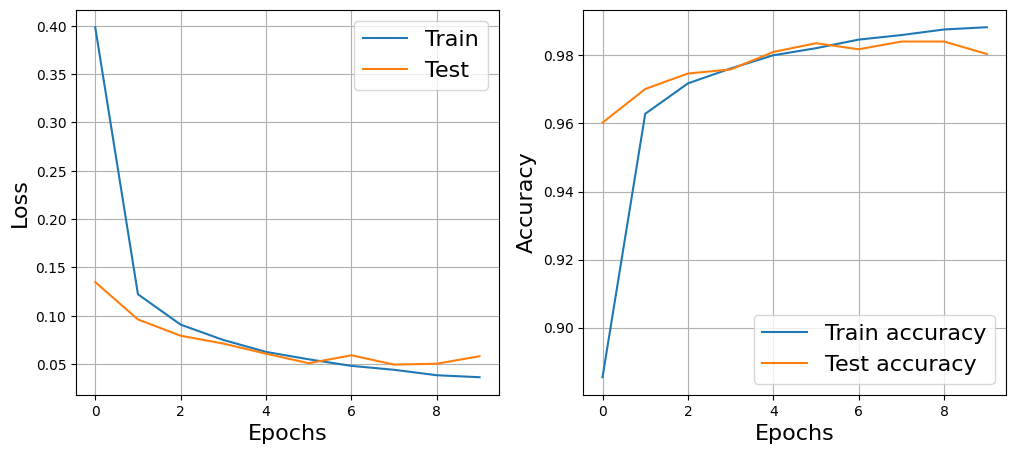

CPU times: user 1min 39s, sys: 2.92 s, total: 1min 42s
Wall time: 1min 39s


([0.3985384635007712,
  0.12225507629086087,
  0.0908363174035478,
  0.07495792212484996,
  0.06263258182274889,
  0.054954672110145854,
  0.04816600831815286,
  0.04411173437529408,
  0.0384861594532678,
  0.036433584318418845],
 [0.13486357127563864,
  0.09621512875715389,
  0.0793523680937441,
  0.07124945568510249,
  0.060751597912793484,
  0.0509241672904714,
  0.059118469929487646,
  0.049479147985937146,
  0.05043701636914423,
  0.05816718408413514],
 [0.88544995,
  0.96284205,
  0.97178173,
  0.97616273,
  0.98004395,
  0.9821262,
  0.98464704,
  0.9859797,
  0.9876233,
  0.98828405],
 [0.96024525,
  0.9701345,
  0.9746835,
  0.97587025,
  0.98101264,
  0.98358387,
  0.9818038,
  0.98407835,
  0.98407835,
  0.9804193])

In [30]:
%%time

#blank
from train_utils import train

sizes_blank = [196, 128, 128, 10]
layers = []
layers_blank = init_layers_drop(sizes_blank, layers)
network_blank = TestNetwork(nn.Sequential(*layers_blank))

train(network_blank, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.497/0.139	Accuracy: 0.846/0.964


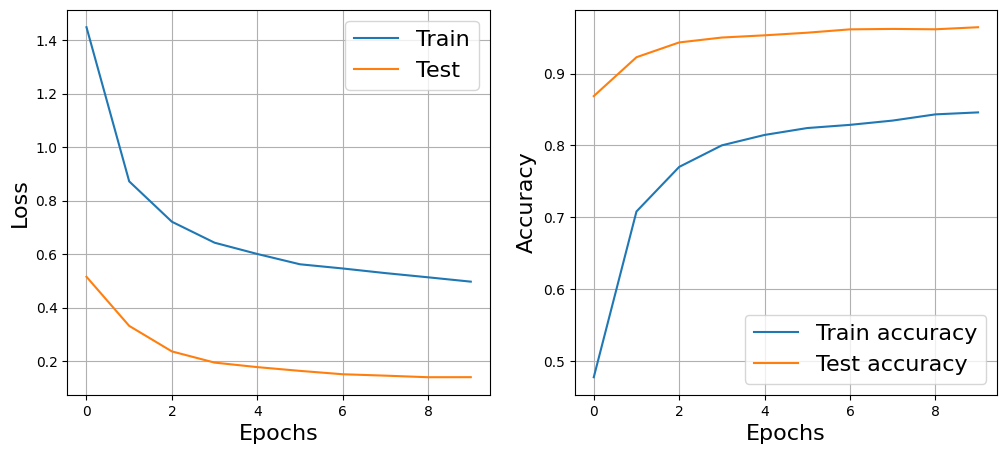

CPU times: user 1min 38s, sys: 2.81 s, total: 1min 41s
Wall time: 1min 38s


([1.4480878480716046,
  0.8716893916699424,
  0.7207200239970486,
  0.6422938347371148,
  0.600167877003074,
  0.5616279757861644,
  0.5459578366421941,
  0.5286494153521971,
  0.5129094122569444,
  0.49667934593615504],
 [0.5149031126800971,
  0.3313016844323919,
  0.23577536100262328,
  0.19398400234647944,
  0.17706530588337138,
  0.16301714921299415,
  0.15043661352011223,
  0.14516831205898448,
  0.13930250487372844,
  0.139485732758347],
 [0.47767857,
  0.70817786,
  0.7701892,
  0.80019546,
  0.8146655,
  0.8242659,
  0.82869136,
  0.83465487,
  0.84327245,
  0.8460266],
 [0.8686709,
  0.922765,
  0.94333464,
  0.95015824,
  0.9532239,
  0.9568829,
  0.96153086,
  0.9621242,
  0.96162975,
  0.9644976])

In [31]:
%%time

#dropout
from train_utils import train

sizes_dropout = [196, 128, 128, 10]
layers = []
layers_dropout= init_layers_drop(sizes_dropout, layers, 'dropout')
network_dropout = TestNetwork(nn.Sequential(*layers_dropout))

train(network_dropout, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.339/0.203	Accuracy: 0.893/0.937


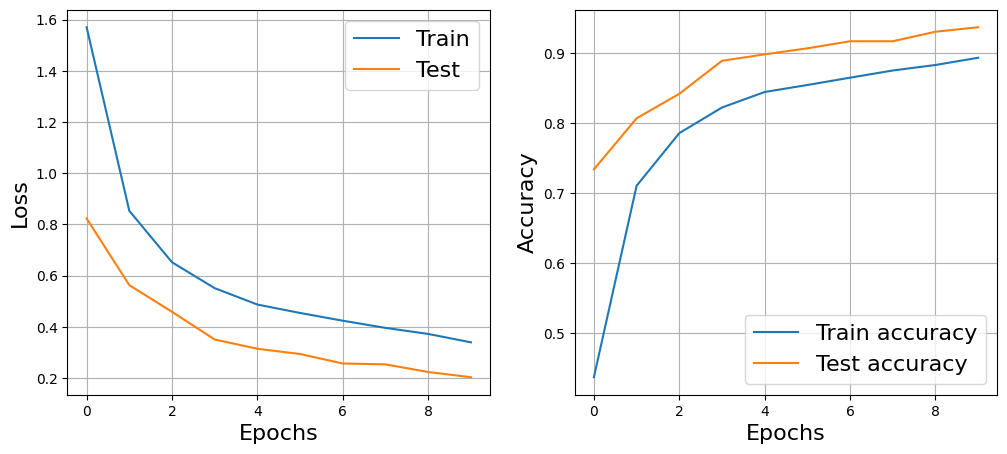

CPU times: user 1min 39s, sys: 2.94 s, total: 1min 42s
Wall time: 1min 39s


([1.5705490314375872,
  0.8530912342102035,
  0.6521725731490772,
  0.550961558752731,
  0.4869781298233248,
  0.4540553535860993,
  0.42382219640303775,
  0.3958373816409853,
  0.37215771692902294,
  0.3393305590920357],
 [0.8232858090461055,
  0.5628897657122793,
  0.45850831590875796,
  0.3503240942955017,
  0.31422961852218534,
  0.29362490792063217,
  0.2566619530980346,
  0.25325852010069017,
  0.2234421877921382,
  0.20305282999820348],
 [0.43762773,
  0.71049887,
  0.78554773,
  0.82209486,
  0.844172,
  0.8541666,
  0.8645834,
  0.87483895,
  0.8826959,
  0.89299595],
 [0.7338805,
  0.80666536,
  0.8415744,
  0.88864714,
  0.89784414,
  0.90644777,
  0.9165348,
  0.9165348,
  0.9300831,
  0.9365111])

In [32]:
%%time

#dropconnect
from train_utils import train

sizes_dropconnect = [196, 128, 128, 10]
layers = []
layers_dropconnect= init_layers_drop(sizes_dropconnect, layers, 'dropconnect')
network_dropconnect = TestNetwork(nn.Sequential(*layers_dropconnect))

train(network_dropconnect, train_loader, test_loader, 10, 0.001)

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

По графикам можно увидеть, что Dropout и Dropconnect помогают бороться с переобучением. На первом же графике мы видим расхождение accuracy на трейне и на тесте

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [47]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, normal_shape, eps=1e-5, elementwise_affine=True):
        super(LayerNormalization, self).__init__()
        normal_shape = (normal_shape, )
        self.normal_shape = normal_shape
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.gain = nn.Parameter(torch.ones(*normal_shape))
            self.bias = nn.Parameter(torch.zeros(*normal_shape))


    def forward(self, x):
        mean = torch.mean(x, dim=(-1), keepdim=True)
        variance = torch.square(x - mean).mean(dim=(-1), keepdim=True)
        output = (x - mean) / torch.sqrt(variance + self.eps)
        if self.elementwise_affine:
            output *= self.gain
            output += self.bias
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [54]:
def init_layers_normalization(sizes, layers, drop=None):
    for size_input, size_output in zip(sizes, sizes[1:]):
        if drop == 'batch':
            layer = nn.Linear(size_input, size_output)
            layers.append(layer)
            layers.append(nn.BatchNorm1d(size_output))
            layers.append(nn.ReLU())
            del layers[-2:]
        elif drop == 'layer':
            layer = nn.Linear(size_input, size_output)
            layers.append(layer)
            layers.append(LayerNormalization(size_output))
            layers.append(nn.ReLU())
            del layers[-2:]
        else:
            layer = nn.Linear(size_input, size_output)
            layers.append(layer)
            layers.append(nn.ReLU())
            del layers[-1]
    return layers

Epoch 19... (Train/Test) NLL: 0.077/0.074	Accuracy: 0.976/0.976


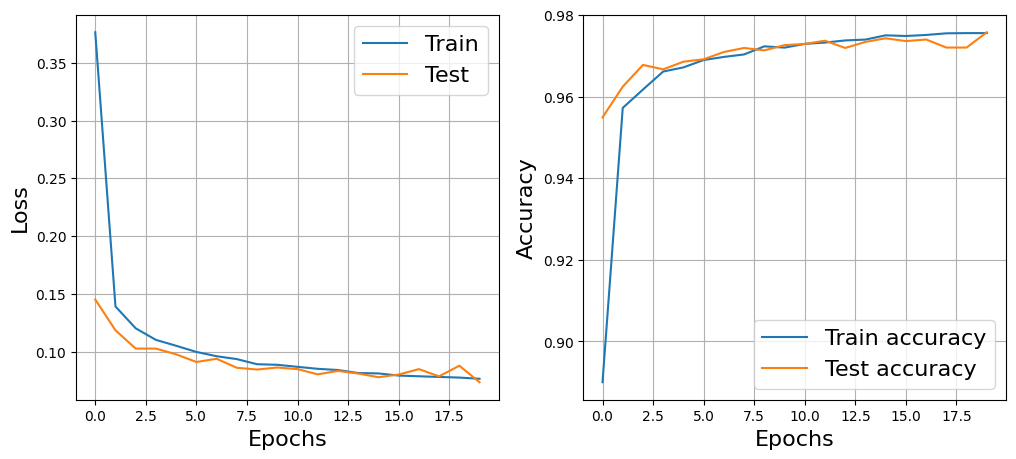

CPU times: user 3min 15s, sys: 5.47 s, total: 3min 21s
Wall time: 3min 14s


([0.3764408648268246,
  0.13924374633919456,
  0.12034698923640667,
  0.11033032886954004,
  0.10524241965828038,
  0.09991495219120847,
  0.0962010091627394,
  0.09371310016557352,
  0.08928147809647484,
  0.08880087817067912,
  0.08703258836161354,
  0.08531277700226063,
  0.084279029300488,
  0.08166757601100816,
  0.08132094330489953,
  0.07947333389992463,
  0.078863410034906,
  0.07827511256628199,
  0.07774232133829803,
  0.07671126563435615],
 [0.14528214988074725,
  0.11861650584430634,
  0.10280847238211692,
  0.10280788307891617,
  0.09783445220865027,
  0.09120940115255645,
  0.09399641618792769,
  0.08622082684754948,
  0.08467729127954078,
  0.08643710806588584,
  0.08505206924120459,
  0.08053761066373767,
  0.08349324523506663,
  0.08121868939716605,
  0.07805572080579173,
  0.08035595067835684,
  0.0850447189251456,
  0.07878883531953715,
  0.08798948543358452,
  0.07371662511148408],
 [0.8900142,
  0.95722836,
  0.96172595,
  0.9661403,
  0.9671564,
  0.9689554,
  0.9

In [55]:
%%time

# without normalizations
from train_utils import train

sizes_clear = [196, 128, 128, 10]
layers = []
layers_clear = init_layers_normalization(sizes_clear, layers)
network_clear = TestNetwork(nn.Sequential(*layers_clear))

train(network_clear, train_loader, test_loader, 20, 0.001)

Epoch 19... (Train/Test) NLL: 0.009/0.064	Accuracy: 0.997/0.984


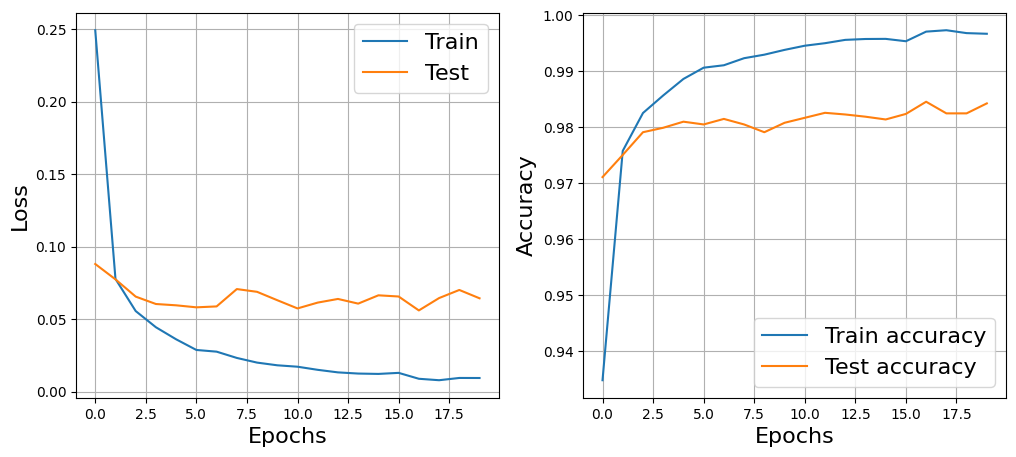

CPU times: user 3min 20s, sys: 4.87 s, total: 3min 25s
Wall time: 3min 19s


([0.2491705379148981,
  0.07778771281409175,
  0.05561892397658053,
  0.04445819275231281,
  0.03615140693454839,
  0.028810435116215588,
  0.02764411270817015,
  0.02331757514915272,
  0.020101570229389583,
  0.018245227836337544,
  0.017268181147886866,
  0.015120501589051871,
  0.013360659120110934,
  0.01254991660554107,
  0.0122989588969403,
  0.013023848419167303,
  0.008954914546278028,
  0.007956984043650047,
  0.009521441095649376,
  0.009483103800510644],
 [0.0880527169549767,
  0.07746328749469941,
  0.06558358510130946,
  0.06048296538146236,
  0.05958091937995787,
  0.058191479466666904,
  0.058821599344027385,
  0.07077730786574038,
  0.06888237774454622,
  0.06310257903312015,
  0.05744031872128761,
  0.061459114869372757,
  0.06397085738975461,
  0.060751141026863666,
  0.06647159388477478,
  0.06565596580134574,
  0.05605732035068677,
  0.06457700387252058,
  0.07016275855130516,
  0.064420731545535],
 [0.9348736,
  0.97580177,
  0.9825593,
  0.98569095,
  0.9886394,
 

In [52]:
%%time

# batch norm
from train_utils import train

sizes_batch = [196, 128, 128, 10]
layers = []
layers_batch = init_layers_normalization(sizes_batch, layers, 'batch')
network_batch = TestNetwork(nn.Sequential(*layers_batch))

train(network_batch, train_loader, test_loader, 20, 0.001)

Epoch 19... (Train/Test) NLL: 0.011/0.069	Accuracy: 0.996/0.983


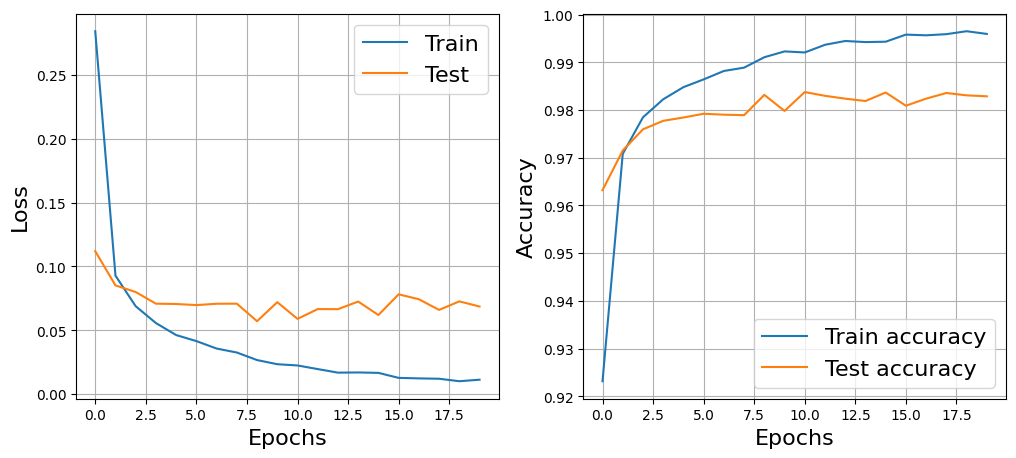

CPU times: user 3min 26s, sys: 5.12 s, total: 3min 31s
Wall time: 3min 26s


([0.28417295207188076,
  0.09275980171427797,
  0.06879886850984747,
  0.05563109362823591,
  0.04622925535392469,
  0.04150339415761581,
  0.03566438380603009,
  0.032556649486123246,
  0.02665508659913945,
  0.0233952623818304,
  0.022426392999477684,
  0.019588929643707554,
  0.016802749447976308,
  0.01694874205960528,
  0.01662437204851894,
  0.0126986722996794,
  0.012299145031636005,
  0.012018949574622602,
  0.010079644684986854,
  0.01127577486449169],
 [0.11192128033954886,
  0.08513077820026421,
  0.07992871102134261,
  0.07079680017018809,
  0.07056370337458351,
  0.06970633429628384,
  0.070747333124893,
  0.07081522017458006,
  0.05709198428777671,
  0.07199706003376388,
  0.05891546018498462,
  0.06656696091854025,
  0.06651478857568265,
  0.07247077459944677,
  0.06192505769313702,
  0.07813562853468134,
  0.07427979297818074,
  0.06592560891736936,
  0.07260911123891754,
  0.06858345756124516],
 [0.9231521,
  0.9708211,
  0.9784837,
  0.982265,
  0.9848081,
  0.9864350

In [53]:
%%time

# layer norm
from train_utils import train

sizes_norm = [196, 128, 128, 10]
layers = []
layers_norm = init_layers_normalization(sizes_norm, layers, 'layer')
network_norm = TestNetwork(nn.Sequential(*layers_norm))

train(network_norm, train_loader, test_loader, 20, 0.001)

<i> 3.3 Сделайте выводы по третьей части </i>

Нормализация помогает повысить как стартовый accuracy на тесте, так и итоговый на том же тесте
Что батч, что лейер справляются с этим хорошо :)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: